# Introduction to PyTorch
__Advanced NLP | MSc CogSys | Potsdam University__

We can install PyTorch following the instructions [here](https://pytorch.org/get-started/locally/). 

This notebook is based on [this tutorial](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e?#ea0d) and on PyTorch's [documentation](https://pytorch.org/docs/stable/index.html).

In [1]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchviz

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
# torch.nn: implements layers, loss functions and activation functions
import torch.nn as nn
# torch.optim: implements optimization algorithms (e.g. SGD)
import torch.optim as optim
# used for activation functions (deprecated?, but still used in PyTorch's github examples)
import torch.nn.functional as F 
# torchviz to visualize computation graphs (needs graphviz)
import torchviz
# we use numpy for some examples
import numpy as np

## GPU

As we saw in the lecture slides, using the Graphics Processing Unit may boost the performance of our program when we are training neural networks. So let us first examine the possibility of using it in our PyTorch code. 

To use the GPU, PyTorch needs [Cuda](https://pytorch.org/docs/stable/notes/cuda.html), which is a Nvidia's API. In general, PyTorch's installation includes it.

We can use ``cuda.is_available()`` to check whether there is any available GPU. If it returns True, we can make our calculations on the GPU. If it returns False, it can either mean that our computer or server has no GPU, or that we missed installing cuda. In that case, all computation will be performed in the CPU.

In [4]:
torch.cuda.is_available()

False

Even if cuda is available, the GPU will not be automatically used. We have to send our data and models to it ourselves. We will see how to do that, but first it is good practice to store the device we want to use in a variable that will be passed as arguments later.

In [5]:
# Use GPU if it is available, otherwise use CPU.
my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('This notebook can use the ' + str(my_device) + ' for running the code.')

This notebook can use the cpu for running the code.


Some servers may have more than one GPU. In that case, we can manually choose which one we would like to use. ``torch.cuda.device_count()`` returns the number of available GPUs, which are numbered starting at 0. If there is more than one, we can refer to them using ``"cuda:0"``, ``"cuda:1"``, ..., ``"cuda:n"``.

In [6]:
# a list with all GPUs
# torch.device("cuda", n) is the same as torch.device("cuda:n")
devices = [torch.device("cuda", n) for n in range(torch.cuda.device_count())]

__Remember__: if we want to use the GPU, all our data, parameters and models must be sent to the GPU, preferably by the time they are created. Trying to combine objects in the CPU with objects in the GPU may throw an error.

## Tensors

Tensors are the fundamental objects in PyTorch. They are n-dimensional arrays, very similar to Numpy arrays, with special methods. 

You can create a simple tensor like this:


In [7]:
# a scalar
tnsr0 = torch.tensor(1)
# a vector
tnsr1 = torch.tensor([1,2,3,4]) 
# a matrix
tnsr2 = torch.tensor([[1,2,3,4], [5,6,7,8]])
# a 3-dimensional tensor
tnsr3 = torch.tensor([ [[1,2,3,4], [5,6,7,8]], [[8,7,6,5], [4,3,2,1]], [[0,2,4,6], [0,3,5,7]] ]) 

print(tnsr0)
print(tnsr1)
print(tnsr2)
print(tnsr3)

tensor(1)
tensor([1, 2, 3, 4])
tensor([[1, 2, 3, 4],
        [5, 6, 7, 8]])
tensor([[[1, 2, 3, 4],
         [5, 6, 7, 8]],

        [[8, 7, 6, 5],
         [4, 3, 2, 1]],

        [[0, 2, 4, 6],
         [0, 3, 5, 7]]])


We can turn a Numpy array into a tensor using ``torch.from_numpy()``:

In [8]:
np_array = np.array([[1,2,3],[4,5,6]])
pytorch_tensor = torch.from_numpy(np_array)
print(pytorch_tensor)

tensor([[1, 2, 3],
        [4, 5, 6]])


By default, tensors are stored at the CPU. We can move it to the GPU when we create it by passing the device as an argument:

In [9]:
tnsr4 = torch.tensor([1,2,3], device=my_device) # my_device can be "cpu", "cuda" or "cuda:n"
tnsr4.device # check in which device is the tensor

device(type='cpu')

We can also change the device of an existing tensor using ``.to()``:

In [10]:
tnsr2.to("cuda:0" if torch.cuda.is_available() else "cpu")

tensor([[1, 2, 3, 4],
        [5, 6, 7, 8]])

However, ``.to()`` shadows a tensor's gradient (we will learn that below), so it is always advisible to create the tensor directly on the GPU using the argument ``device``.

When we create a tensor, we can also specify the desired [data type](https://pytorch.org/docs/stable/tensor_attributes.html#torch.torch.dtype), e.g. ``torch.float``, ``torch.double``, ``torch.long``. If no argument is given, the data type will be inferred.

In [11]:
tnsr5 = torch.tensor([1,2,3], device=my_device, dtype=torch.double)

Empty tensors or tensors filled with zeros / random numbers are created by passing the desired dimensions to ``torch.empty()``, ``torch.zeros()`` and ``torch.rand()``, respectively:

In [12]:
# empty tensor means no values assigned yet, so it is initilized with 'garbage values'
empty = torch.empty(4, 3, device=my_device) 
zeros = torch.zeros(4, 3, device=my_device)
rnd = torch.rand(4, 3, device=my_device)
print(empty)
print(zeros)
print(rnd)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
tensor([[0.2300, 0.7323, 0.1346],
        [0.5182, 0.9310, 0.8103],
        [0.7237, 0.9281, 0.3131],
        [0.7781, 0.9693, 0.8765]])


We can check the shape of a tensor using ``.shape`` or ``.size()``. In our example, tnsr3 has 3 dimensions. The first has size 3 (number of 'matrices'), the second has size 2 (number of rows) and the third has size 4 (number of columns).

In [13]:
tnsr3.shape

torch.Size([3, 2, 4])

To change the dimensions of a tensor, we use ``.view()``:

In [14]:
tnsr6 = tnsr2.view(-1, 2) # meaning we want 2 columns, and -1 let it infer the number of needed rows
tnsr6.shape, tnsr2.shape

(torch.Size([4, 2]), torch.Size([2, 4]))

Whenever we want to specify only one dimension and let PyTorch infer the remaining dimensions of a tensor, we can use -1 for the unspecified dimensions.

If we want to build a new tensor that has the same shape, device and data type of another one, but is filled with zeros or ones, we can use ``zeros_like()`` and ``ones_like()``, respectively.

In [15]:
tnsr7 = torch.ones_like(tnsr3)
tnsr7

tensor([[[1, 1, 1, 1],
         [1, 1, 1, 1]],

        [[1, 1, 1, 1],
         [1, 1, 1, 1]],

        [[1, 1, 1, 1],
         [1, 1, 1, 1]]])

``dir(a_tensor)`` returns a description of all methods related to a tensor. Several of them are similar to those in a Numpy array. Some useful ones are:
- ``.item()``: returns the value of a tensor as a plain Python number
- ``.numpy()``: converts a tensor into a Numpy array (tensor must be on CPU)
- ``.device()``: returns tensor location (CPU or GPU)
- ``.type()``: returns data type of a tensor

__Important tip__: it is really easy to get lost with the dimensions of tensors, and the dimensions of inputs and outputs of layers and functions. A good practice is including comments with the number of dimensions, their size and what they represent for each tensor and inputs/outputs.

## Autograd

[Autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py) is PyTorch's package of automatic differentiation for operations involving tensors. It ["records a graph recording all of the operations that created the data as you execute operations, giving you a directed acyclic graph whose leaves are the input tensors and roots are the output tensors"](https://pytorch.org/docs/stable/notes/autograd.html).

Whenever we create a tensor, we can decide if such values require a gradient computation using the argument ``requires_grad``. It is False by default. If set to True, all operations involving such tensor will keep track of the backward operations required to compute its gradient, using the chain rule for derivation. 

All parameters we want to train in a neural network (weights) should thus be tensors whose argument requires_grad is set to True. Parameters that remain fixed during training and data tensors requires no gradient computation, so we should not waste memory by trying to keep their gradients.

Gradients can only be recorded with tensors whose data type is floating point.

In [16]:
params = torch.tensor([1,2,3], device=my_device, requires_grad=True, dtype=torch.float) 
data = torch.tensor([10,10,10], device=my_device, requires_grad=False, dtype=torch.float)
result = params.dot(data)
result, result.requires_grad

(tensor(60., grad_fn=<DotBackward>), True)

Notice that we created a tensor of parameters (that requires gradient computation) and a tensor of data. Whenever we use a tensor that requires gradient in a function, the resulting tensor will also require a gradient, besides having an attribute ``.grad_fn`` that explicitly tells which backward operation is needed for PyTorch to calculate the gradient at this step during backpropagation.

In [17]:
(params.grad_fn, data.grad_fn, result.grad_fn) # None when there was no function involved on the creation

(None, None, <DotBackward at 0x106ca3c50>)

The gradient of a tensor is accumulated into its ``.grad`` attribute. Until we perform backpropagation, it is empty:

In [18]:
params.grad, data.grad, result.grad

(None, None, None)

When we finish computing our goal result (normally the loss function in a neural network), we call the method ``.backward()`` on the final tensor. This will automatically compute all gradients. Let us see that with a pseudo loss function:

In [19]:
loss = result**2
loss

tensor(3600., grad_fn=<PowBackward0>)

In [20]:
loss.backward()

It may look like nothing happened. But we can see the difference on the ``.grad``attributes of all initial tensors that required gradient:

In [21]:
params.grad, data.grad, result.grad, loss.grad

(tensor([1200., 1200., 1200.]), None, None, None)

Our params tensor has now the value of the gradient for each respective entry. Although result and loss are tensors whose flag requires_grad was set to true, they were simply intermediate steps in the computation of the loss. They serve to keep track of the reverse operations needed for backpropagation, but only the original parameters (whose attributes ``.is_leaf AND .requires_grad`` are True) will have computed gradient values after using the ``.backward()`` method.

``.is_leaf`` refers to the tensor being a leaf on the computation graph. Let us see how it works:

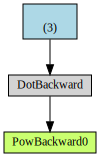

In [22]:
# check the computation graph of a function
torchviz.make_dot(loss)

- Blue boxes: parameters of our model, for which we need to compute gradients
- Gray boxes: an operation that involves gradient computing tensors
- Green box: starting point to compute gradients, if we call ``.backward()`` on this variable


Let us built a more elaborate example:

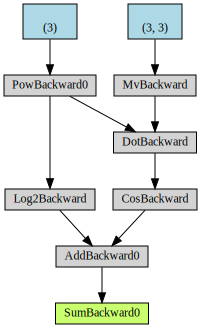

In [23]:
params1 = torch.tensor([[1,1,1], [2,2,2], [3,3,3]], device=my_device, requires_grad=True, dtype=torch.float)
params2 = torch.tensor([0.5, 0.1, 0.9], device=my_device, requires_grad=True, dtype=torch.float)
data = torch.tensor([10, 10, 10], device=my_device, requires_grad=False, dtype=torch.float)

aux1 = params1.matmul(data)
aux2 = params2**0.5
aux3 = aux2.dot(aux1)
aux4 = aux3.cos() + aux2.log2()

loss = aux4.sum()

torchviz.make_dot(loss)

Notice that the tensor data is not shown in the computation graph, because it only presents gradient computing tensors and their dependencies. Still, we know that the data tensor was needed for the gray box MvBackward.

Let us perform backpropagation on this loss:

In [24]:
loss.backward()

In [25]:
params1.grad, params2.grad

(tensor([[2.0195, 2.0195, 2.0195],
         [0.9032, 0.9032, 0.9032],
         [2.7095, 2.7095, 2.7095]]),
 tensor([ 7.5013, 34.3085, 14.3490]))

When we perform gradient descent, we need to update the parameters using the newly computed gradient values. We could do it manually by calling ``params1 = params1 - params1.grad``, but it can be really cumbersome when we have many parameters at different steps in a model.

PyTorch provides optimizers that can do that automatically and more efficiently. Before learning about them on the next section, there is an important reminder to finish this part.

The computation of gradients is cumulative. PyTorch keeps track of operations until we explicitly give a command to disconnet the next computations from the past. For instance, in gradient descent: we output predictions, compute the loss, compute the gradients, update the parameters. An iteration is now finished and we will restart all over. We do not want PyTorch to try to backpropagate the error back to the first iteration. 

To avoid that, we could manually restart the gradients:

In [26]:
params1.grad.zero_()
params2.grad.zero_()

tensor([0., 0., 0.])

Luckily, PyTorch optimizers can also do that automatically with a simple comand that we will examine in the next section.

We can also use ``.detach()`` to detach a tensor from the computation history, e.g. to create a new tensor with the current value of another one but without its gradient history. This new tensor can be used for other purposes and further computation that is independent of how the original values were created.

In [27]:
new_loss = loss.detach()
torchviz.make_dot(new_loss)

## Optimizers

PyTorch's package [torch.optim](https://pytorch.org/docs/stable/optim.html?highlight=optimizers) implements several common optimization methods such as SGD, Adam, AdaGrad, RMSprop etc. It lets us easily choose the learning rate, momentum and other hyperparameters, perform updating steps in our models with the method ``.step()`` and clean gradient history with the ``.zero_grad()`` method.

Let us use the Adam optimizer to perform a gradient descent step in the loss function we computed above.

We first choose an optimizer and pass a list of parameters:

In [28]:
params1 = torch.tensor([[1,1,1], [2,2,2], [3,3,3]], device=my_device, requires_grad=True, dtype=torch.float)
params2 = torch.tensor([0.5, 0.1, 0.9], device=my_device, requires_grad=True, dtype=torch.float)

# first instantiate an optim object with the model's parameters and the optimizer's specific hyperparameters
optimizer = optim.Adam([params1, params2], lr=0.0001) 

Let us build the loss again and call the ``.step()`` method:

In [29]:
data = torch.tensor([10, 10, 10], device=my_device, requires_grad=False, dtype=torch.float)

aux1 = params1.matmul(data)
aux2 = params2**0.5
aux3 = aux2.dot(aux1)
aux4 = aux3.cos() + aux2.log2()

loss = aux4.sum()

loss.backward()

optimizer.step()

In [30]:
params1, params2 # check new parameters after one update in gradient descent

(tensor([[0.9999, 0.9999, 0.9999],
         [1.9999, 1.9999, 1.9999],
         [2.9999, 2.9999, 2.9999]], requires_grad=True),
 tensor([0.4999, 0.0999, 0.8999], requires_grad=True))

In [31]:
params1.grad, params2.grad # check how the optimizer computed and stored the gradients

(tensor([[2.0195, 2.0195, 2.0195],
         [0.9032, 0.9032, 0.9032],
         [2.7095, 2.7095, 2.7095]]),
 tensor([ 7.5013, 34.3085, 14.3490]))

We must then call ``optimizer.zero_grad()`` to make sure that the gradient computation starts again in the next step.

In [32]:
optimizer.zero_grad() 

In [33]:
params1.grad, params2.grad # check how the optimizer zeroed the previous gradients

(tensor([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]),
 tensor([0., 0., 0.]))

## Loss functions

We have used a psedo loss function so far. However, neural network models normally use more elaborate loss functions like mean squared error, cross entropy, hinge etc. 

The most usual loss functions are already implemented in PyTorch's [``.nn`` package](https://pytorch.org/docs/stable/nn.html) with their corresponding gradient computation: L1Loss, MSELoss, CrossEntropyLoss, CTCLoss, NLLLoss, PoissonNLLLoss, KLDivLoss, BCELoss, BCEWithLogitsLoss, MarginRankingLoss,  HingeEmbeddingLoss, MultiLabelMarginLoss, SmoothL1Loss, SoftMarginLoss, MultiLabelSoftMarginLoss, CosineEmbeddingLoss, MultiMarginLoss and TripletMarginLoss.

Here is an example using the cross entropy with a single, non-normalized output scores and a golden class.

In [34]:
# we first instantiate a loss object, eventually passing the arguments with its hyperparameters
crss_entrp = nn.CrossEntropyLoss()
scores = torch.tensor([[-5, 21, 30]], dtype=torch.float)
gold = torch.tensor([2])

loss = crss_entrp(scores, gold)
loss

tensor(0.0001)

Let us build a simple model Ax=y, where x is our data and A are parameters, and suppose that we know the correct output Y:

In [35]:
A = torch.rand(3,3, device=my_device, requires_grad=True) # random initialization of our parameters
x = torch.tensor([0.1, 0.2, 0.3], device=my_device, requires_grad=True)

y = A.matmul(x)
Y = torch.tensor([0.2, 0.3, 0.4])

We first instantiate a loss function from a class in ``torch.nn``:

In [36]:
mse = torch.nn.MSELoss()

Then we calculate the loss by passing the output of our model and the true answers to the function:

In [37]:
loss = mse(y, Y)

After that, we can continue the optimization as above:

In [38]:
loss.backward()    
optimizer.step()
optimizer.zero_grad()

## Activation Functions

PyTorch's ``torch.nn`` module provides implementations of many [activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity): ELU, Hardshrink, Hardtanh, LeakyReLU, LogSigmoid, MultiheadAttention, PReLU, ReLU, ReLU6, RReLU, SELU, CELU, Sigmoid, Softplus, Softshrink, Softsign, Tanh, Tanhshrink, Threshold, Softmin, Softmax, Softmax2d, LogSoftMax, AdaptiveLogSoftmaxWithLoss.

Let us see how to create a Softmax and a ReLU layer:

In [39]:
# we must first instantiate a class, then use it with our tensor as argument
# calling F.softmax(output, dim=-1) would also work as a function, instead of a class

softmax_layer = nn.Softmax(dim=-1)
example_output = torch.tensor([-1,-2,3], dtype=torch.float)
softmax_layer(example_output)

tensor([0.0179, 0.0066, 0.9756])

In [40]:
# calling F.relu(example_output) would also work as a function, instead of a class

relu_layer = nn.ReLU()
relu_layer(example_output)

tensor([0., 0., 3.])

## Neural Network Models

We have covered some important building blocks for training neural networks, but we still need to explore the models themselves. Like the loss functions, the main types of layers that compose a neural network (for instance, linear, convolutional, pooling, recurrent, dropout and transformer layer) are also implemented in the [``.nn`` package](https://pytorch.org/docs/stable/nn.html) as classes.

All neural network models derive from a base class called Module. Whenever we create a new model, we should inherit the base class and write its ``__init__(self)`` method (where we define all layers) and ``forward(self, input)`` method (where we define the forward pass that returns an output).

The ``.forward()`` method should not be explicitly called though. PyTorch is built to work like that, calling the model instance itself with the arguments demanded by the ``.forward()`` method will take care of everything that must happen in the background.

Let us see some examples:

In [41]:
# Source: https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e?#ea0d

class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.a + self.b * x

For a simple linear regression, the class ManualLinearRegression defines two parameters, initializing them randomly. The forward method returns the result of ax+b. 

The class ``nn.Parameter()`` is a subclass of ``Tensor``, which is automatically included into the model's parameters when we instantiate a subclass of ``nn.Module``.

When we use PyTorch's implementation, we do not need to define the parameters explicitly when we choose a built-in layer. The ``LayerLinearRegression`` below is another way to do the same thing as ``ManualLinearRegression()`` using PyTorch resources: 

In [42]:
# Source: https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e?#ea0d

class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)

Another more elaborate example:

In [43]:
# Source: https://github.com/pytorch/examples/blob/master/mnist/main.py, modified

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) 
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)   # probability of an element to be zero-ed = 0.25
        self.dropout2 = nn.Dropout2d(0.5)    # probability of an element to be zero-ed = 0.5
        self.fc1 = nn.Linear(9216, 128)      # input with 9216 dims, output with 128 dims
        self.fc2 = nn.Linear(128, 10)        # input with 128 dims, output with 10 dims

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
    
        return output
    
# The use of torch.nn.functional is deprecated according to https://discuss.pytorch.org/t/torch-tanh-vs-torch-nn-functional-tanh/15897.
# We keep it here because we can still find it on existing codes, however all activation functions are available
# on the module torch.nn as classes

For classifying MNIST digits, they create a more elaborate class called Net, which inherits from the base class Module. This model uses some of the many implemented layers in ``torch.nn``.

The model is initialized with two convolutional layers, two dropout layers and two linear layers. Its forward method defines the forward pass: the input goes through convolution, ReLu, convolution, pooling, dropout, linearization, ReLu, droupout, linearizarion and softmax.

Let us use the ManualLinearRegression model:

In [44]:
# example input and correct output
x = torch.tensor([4], device=my_device)
y_gold = 5

model = ManualLinearRegression().to(my_device) # the model must be in the same device as the data

output = model(x)

# Check the values:
print(model.a, model.b, output)

Parameter containing:
tensor([-1.7093], requires_grad=True) Parameter containing:
tensor([0.9611], requires_grad=True) tensor([2.1351], grad_fn=<AddBackward0>)


In [45]:
error = (output - y_gold)**2
error.backward()
model.a.grad, model.b.grad # gradients have been computed for our parameters

(tensor([-5.7298]), tensor([-22.9192]))

See how the LayerLinearRegression does the same thing:

In [46]:
x = torch.tensor([4], device=my_device, dtype=torch.float)
y_gold = 5
model2 = LayerLinearRegression().to(my_device) # the model must be in the same device as the data

output2 = model2(x)
[*model2.parameters(), output2]

[Parameter containing:
 tensor([[-0.3132]], requires_grad=True),
 Parameter containing:
 tensor([-0.2520], requires_grad=True),
 tensor([-1.5047], grad_fn=<AddBackward0>)]

To check the values of the parameters in our model, we can use the generator ``.parameters()`` as above or call ``.state_dict()``:

In [47]:
model.state_dict()

OrderedDict([('a', tensor([-1.7093])), ('b', tensor([0.9611]))])

In [48]:
model2.state_dict()

OrderedDict([('linear.weight', tensor([[-0.3132]])),
             ('linear.bias', tensor([-0.2520]))])

Or as a generator again, but with the corresponding names of the many parameters in the Net() model:

In [49]:
net = Net()
[*net.named_parameters()] # named_parameters is a generator object

[('conv1.weight',
  Parameter containing:
  tensor([[[[-0.0349,  0.0733,  0.2607],
            [ 0.2581, -0.1028, -0.3061],
            [ 0.1565,  0.0457, -0.1409]]],
  
  
          [[[-0.0746, -0.1595,  0.2466],
            [-0.0153, -0.0344, -0.2042],
            [-0.3004,  0.1129, -0.0500]]],
  
  
          [[[-0.2825,  0.1571, -0.1058],
            [ 0.0805,  0.0651, -0.3140],
            [ 0.0989, -0.3053, -0.2760]]],
  
  
          [[[-0.2364,  0.1116,  0.1939],
            [ 0.2203, -0.2199,  0.3037],
            [-0.0075,  0.0749, -0.0261]]],
  
  
          [[[ 0.3286, -0.2233,  0.2126],
            [ 0.3013,  0.0083, -0.2701],
            [ 0.2544, -0.0204,  0.2165]]],
  
  
          [[[ 0.2446, -0.2538, -0.0976],
            [-0.0809,  0.2100,  0.2077],
            [-0.1664, -0.3275, -0.1410]]],
  
  
          [[[ 0.2558,  0.0590, -0.2238],
            [ 0.2576, -0.1847,  0.1542],
            [-0.2411,  0.0207,  0.3111]]],
  
  
          [[[ 0.1280,  0.0309, -0.0903],


## Other tips 

[Reproducibility](https://pytorch.org/docs/stable/notes/randomness.html?highlight=reproducibility): we can give a seed value to the random number generator at the beginning of our code, so that we can reproduce the randomly initiliazed values of our model (e.g. the weights of a neural network).

In [50]:
torch.manual_seed(22) # choose any integer

[Weight initialization](https://pytorch.org/docs/stable/nn.init.html?highlight=initialization): each layer implemented in PyTorch has a default weight initialization method. Still, we can choose one of the many initialization methods implemented on ``torch.nn.init``. After we create a layer, we can use them to initialize the weights:

In [51]:
fc1 = nn.Linear(10, 5)
torch.nn.init.uniform_(fc1.weight, a=0.0, b=1.0) # uniform random initializtion with numbers between 0 and 1
torch.nn.init.uniform_(fc1.bias, a=0.0, b=1.0)

Parameter containing:
tensor([0.6550, 0.5360, 0.5379, 0.3995, 0.5657], requires_grad=True)

Most layers include a bias term as default. We can change that by setting the argument ``bias`` to False when we instantiate a layer.

In [52]:
lstm1 = nn.LSTM(5, 2)
lstm2 = nn.LSTM(5, 2, bias=False)

print(*lstm1.named_parameters(), '\n')
print(*lstm2.named_parameters())

('weight_ih_l0', Parameter containing:
tensor([[-0.0105,  0.6447,  0.7000, -0.6737,  0.5332],
        [ 0.5382,  0.5996, -0.1174, -0.3737,  0.3098],
        [-0.2072,  0.5853, -0.5919,  0.1770, -0.1372],
        [ 0.3013, -0.5669, -0.2654,  0.1224,  0.3774],
        [-0.5567,  0.5766,  0.1534, -0.4828, -0.0714],
        [-0.5483,  0.3734,  0.2936, -0.1256,  0.4017],
        [ 0.0801, -0.1223, -0.6987, -0.2561, -0.5731],
        [ 0.5322,  0.5665, -0.3863, -0.2940, -0.2376]], requires_grad=True)) ('weight_hh_l0', Parameter containing:
tensor([[-0.6883, -0.1375],
        [-0.0822, -0.5835],
        [ 0.6837, -0.5780],
        [-0.1257,  0.2416],
        [ 0.5828, -0.5169],
        [-0.1703, -0.1890],
        [-0.2718,  0.1064],
        [-0.5787, -0.2178]], requires_grad=True)) ('bias_ih_l0', Parameter containing:
tensor([ 0.5380,  0.4018,  0.6273, -0.1422, -0.0426,  0.2606,  0.2750, -0.0779],
       requires_grad=True)) ('bias_hh_l0', Parameter containing:
tensor([ 0.1559,  0.0214, -0.01

When we are not training our model, we can envelope a code snippet under ``with torch.no_grad():``. Whithin this command, PyTorch will not track the gradient, which can be more efficient (less memory consumption) when we know we will not need to compute it (e.g. during test).

During evaluation, we can call ``model.eval()`` to enable the evaluation mode, which results in a different behavior that some layers should have when we are not training a model. For example, droupout normally happens only during training, but not during testing. This command thus avoids having to check all layers manually or building a separate model. During training, we must call ``model.train()`` to set it back to training mode.

If we want to use gradient clipping, we can call ``torch.nn.utils.clip_grad_norm_(parameters, max_norm)`` after backpropagation but before updating the parameters.

Methods and functions that end with an _ perform in-place modifications. Both options are normally available for the usual operations on tensors.

In [53]:
a = torch.tensor([1,2])
b = torch.tensor([2,3])

a.add_(3) # in-place modification, a changes
b.add(3) # b does not change, could be printed or stored in another variable
c = b.add(3)

print(a)
print(b)
print(c)

tensor([4, 5])
tensor([2, 3])
tensor([5, 6])


``torch.save()`` can be used to save a model to the disk.

For further important commands, also check PyTorch's [cheat sheet](https://pytorch.org/tutorials/beginner/ptcheat.html).